In [28]:
from langgraph.graph import StateGraph, START, END
from langchain_google_genai import ChatGoogleGenerativeAI
from pydantic import BaseModel, Field
from dotenv import load_dotenv
from typing import Optional,Annotated,operator



In [29]:
load_dotenv()
model= ChatGoogleGenerativeAI(model="gemini-2.5-flash")



In [30]:
class struct_output_state(BaseModel):
    summary:str= Field(description="write the summary how its written on the basis of given context ")
    score:float = Field(le=10,ge=0,description="give the score of summary out of 10 it can be in float ")
    

In [31]:
class upscState(BaseModel):
    essay:str
    cot_summary :Optional[str]=None 
    language_summary:Optional[str]=None 
    scores: Annotated[Optional[list[float]],operator.add]=None

In [32]:
struct_model= model.with_structured_output(struct_output_state)



In [33]:
def thought_clarity_node(state:upscState)->upscState:
    prompt= f""" you are an agent which give the rating to the {state.essay} and you have to rate it out of 10 on the clarity of thought  """
    res:struct_output_state=struct_model.invoke(prompt)
    return {"cot_summary":res.summary,"scores":[res.score]}
    

In [34]:
def language_node(state:upscState)->upscState:
    prompt= f""" you are an agent which give the rating to the {state.essay} and you have to rate it out of 10 on the language  """
    res:struct_output_state=struct_model.invoke(prompt)
    return {"language_summary":res.summary,"scores":[res.score]}
    

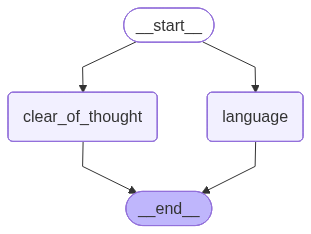

In [35]:

graph = StateGraph(upscState)

graph.add_node("clear_of_thought",thought_clarity_node)
graph.add_node("language",language_node)

graph.add_edge(START,"clear_of_thought")
graph.add_edge(START,"language")
graph.add_edge("clear_of_thought",END)
graph.add_edge("language",END)

workflow = graph.compile()
workflow




In [37]:
initial_state= {
    "essay":"India is a big country and so many people living here. It have many states and languages also food is different everywhere. People doing festivals every time like Diwali, Holi, etc. It got freedom in 1947 from British. Now India is developing and people doing good jobs and all."
    
}

result=workflow.invoke(initial_state)
print(result)

{'essay': 'India is a big country and so many people living here. It have many states and languages also food is different everywhere. People doing festivals every time like Diwali, Holi, etc. It got freedom in 1947 from British. Now India is developing and people doing good jobs and all.', 'cot_summary': 'The provided text describes India as a large and populous country with diverse states, languages, and food. It highlights the frequent celebration of festivals like Diwali and Holi, its independence from British rule in 1947, and its ongoing development with people engaged in good jobs.', 'language_summary': 'The provided text describes India as a large and populous country with diverse states, languages, and food. It mentions frequent festivals, its independence in 1947, and its ongoing development.', 'scores': [6.5, 6.0]}
